# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from ast import literal_eval
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
#Constants
MISSING_RATE = 0.2 # tolerable rate for column missing values
THRESHOLD = 25 #  tolerable  number for row missing values
BINARY_VALUE_NB = 2 # Max number of binary variables for categorical columns
MAX_NB_MULTI_LEVEL_VARIABLES = 15 # Max number of multi-level variables for categorical columns
PCA_N_COMPONENTS = 80


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,OST_WEST_KZ,person,ordinal,[-1]
freq,1,43,49,26


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.
count_null = azdias.isnull().sum()
for index in count_null.index:
    if count_null[index] > 0:
        print(index, count_null[index])

CJT_GESAMTTYP 4854
GFK_URLAUBERTYP 4854
LP_LEBENSPHASE_FEIN 4854
LP_LEBENSPHASE_GROB 4854
LP_FAMILIE_FEIN 4854
LP_FAMILIE_GROB 4854
LP_STATUS_FEIN 4854
LP_STATUS_GROB 4854
RETOURTYP_BK_S 4854
SOHO_KZ 73499
TITEL_KZ 73499
ALTER_HH 73499
ANZ_PERSONEN 73499
ANZ_TITEL 73499
HH_EINKOMMEN_SCORE 18348
KK_KUNDENTYP 584612
W_KEIT_KIND_HH 107602
WOHNDAUER_2008 73499
ANZ_HAUSHALTE_AKTIV 93148
ANZ_HH_TITEL 97008
GEBAEUDETYP 93148
KONSUMNAEHE 73969
MIN_GEBAEUDEJAHR 93148
OST_WEST_KZ 93148
WOHNLAGE 93148
CAMEO_DEUG_2015 98979
CAMEO_DEU_2015 98979
CAMEO_INTL_2015 98979
KBA05_ANTG1 133324
KBA05_ANTG2 133324
KBA05_ANTG3 133324
KBA05_ANTG4 133324
KBA05_BAUMAX 133324
KBA05_GBZ 133324
BALLRAUM 93740
EWDICHTE 93740
INNENSTADT 93740
GEBAEUDETYP_RASTER 93155
KKK 121196
MOBI_REGIO 133324
ONLINE_AFFINITAET 4854
REGIOTYP 121196
KBA13_ANZAHL_PKW 105800
PLZ8_ANTG1 116515
PLZ8_ANTG2 116515
PLZ8_ANTG3 116515
PLZ8_ANTG4 116515
PLZ8_BAUMAX 116515
PLZ8_HHZ 116515
PLZ8_GBZ 116515
ARBEIT 97216
ORTSGR_KLS9 97216
RELAT_AB

In [11]:
#check missing values format/types
feat_info.missing_or_unknown.value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[XX]         1
[-1,XX]      1
[-1,X]       1
[-1,0,9]     1
Name: missing_or_unknown, dtype: int64

In [12]:
feat_info.missing_or_unknown.replace('[-1,XX]', "[-1,'XX']", inplace = True)
feat_info.missing_or_unknown.replace('[XX]', "['XX']", inplace = True)
feat_info.missing_or_unknown.replace('[-1,X]', "[-1,'X']", inplace = True)

In [13]:
#check missing values format/types
feat_info.missing_or_unknown.value_counts()

[-1]         26
[-1,9]       17
[-1,0]       16
[0]          12
[]           10
['XX']        1
[-1,'XX']     1
[-1,0,9]      1
[-1,'X']      1
Name: missing_or_unknown, dtype: int64

In [14]:
#parse all to list
feat_info.missing_or_unknown = feat_info.missing_or_unknown.apply(literal_eval)

In [15]:
feat_info.missing_or_unknown.head()

0       [-1, 0]
1    [-1, 0, 9]
2       [-1, 0]
3           [0]
4          [-1]
Name: missing_or_unknown, dtype: object

In [16]:
feat_info.set_index('attribute', inplace=True)

In [17]:
# Convert missing values to NaNs
for column in tqdm(azdias.columns):
    missing_values_row = azdias[column].isin(feat_info.at[column, 'missing_or_unknown'])
    azdias.at[missing_values_row, column] = np.NaN

100%|██████████| 85/85 [00:12<00:00,  6.79it/s]


In [18]:
print("Result 1 : {}".format(azdias.shape))

Result 1 : (891221, 85)


In [19]:
# Check missing or unknown data values after convert them to NaNs.

count_null = azdias.isnull().sum()
for index in count_null.index:
    if count_null[index] > 0:
        print(index, count_null[index])

AGER_TYP 685843
ALTERSKATEGORIE_GROB 2881
CJT_GESAMTTYP 4854
GEBURTSJAHR 392318
GFK_URLAUBERTYP 4854
HEALTH_TYP 111196
LP_LEBENSPHASE_FEIN 97632
LP_LEBENSPHASE_GROB 94572
LP_FAMILIE_FEIN 77792
LP_FAMILIE_GROB 77792
LP_STATUS_FEIN 4854
LP_STATUS_GROB 4854
NATIONALITAET_KZ 108315
PRAEGENDE_JUGENDJAHRE 108164
RETOURTYP_BK_S 4854
SHOPPER_TYP 111196
SOHO_KZ 73499
TITEL_KZ 889061
VERS_TYP 111196
ALTER_HH 310267
ANZ_PERSONEN 73499
ANZ_TITEL 73499
HH_EINKOMMEN_SCORE 18348
KK_KUNDENTYP 584612
W_KEIT_KIND_HH 147988
WOHNDAUER_2008 73499
ANZ_HAUSHALTE_AKTIV 99611
ANZ_HH_TITEL 97008
GEBAEUDETYP 93148
KONSUMNAEHE 73969
MIN_GEBAEUDEJAHR 93148
OST_WEST_KZ 93148
WOHNLAGE 93148
CAMEO_DEUG_2015 99352
CAMEO_DEU_2015 99352
CAMEO_INTL_2015 99352
KBA05_ANTG1 133324
KBA05_ANTG2 133324
KBA05_ANTG3 133324
KBA05_ANTG4 133324
KBA05_BAUMAX 476524
KBA05_GBZ 133324
BALLRAUM 93740
EWDICHTE 93740
INNENSTADT 93740
GEBAEUDETYP_RASTER 93155
KKK 158064
MOBI_REGIO 133324
ONLINE_AFFINITAET 4854
REGIOTYP 158064
KBA13_ANZAHL_

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [20]:
columns_missing_value_rate = azdias.isnull().sum()/azdias.shape[0]
columns_missing_value_rate

AGER_TYP                 0.769554
ALTERSKATEGORIE_GROB     0.003233
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.005446
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
GEBURTSJAHR              0.440203
GFK_URLAUBERTYP          0.005446
GREEN_AVANTGARDE         0.000000
HEALTH_TYP               0.124768
LP_LEBENSPHASE_FEIN      0.109549
LP_LEBENSPHASE_GROB      0.106115
LP_FAMILIE_FEIN          0.087287
LP_FAMILIE_GROB          0.087287
LP_STATUS_FEIN           0.005446
LP_STATUS_GROB           0.005446
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
RETOURTYP_BK_S           0.005446
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST    

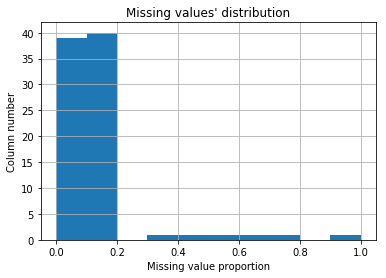

In [21]:
columns_missing_value_rate.hist()
plt.xlabel('Missing value proportion')
plt.ylabel('Column number')
plt.title("Missing values' distribution");

In [22]:
columns_to_keep = columns_missing_value_rate[columns_missing_value_rate < MISSING_RATE]
print(columns_to_keep)

ALTERSKATEGORIE_GROB     0.003233
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.005446
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
GFK_URLAUBERTYP          0.005446
GREEN_AVANTGARDE         0.000000
HEALTH_TYP               0.124768
LP_LEBENSPHASE_FEIN      0.109549
LP_LEBENSPHASE_GROB      0.106115
LP_FAMILIE_FEIN          0.087287
LP_FAMILIE_GROB          0.087287
LP_STATUS_FEIN           0.005446
LP_STATUS_GROB           0.005446
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
RETOURTYP_BK_S           0.005446
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST               0.000000
SEMIO_ERL                0.000000
SEMIO_KULT    

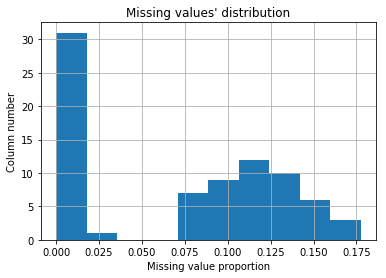

In [23]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
columns_to_keep.hist()
plt.xlabel('Missing value proportion')
plt.ylabel('Column number')
plt.title("Missing values' distribution");

In [24]:
columns_to_drop = columns_missing_value_rate[columns_missing_value_rate > MISSING_RATE].index

  0%|          | 0/6 [00:00<?, ?it/s]

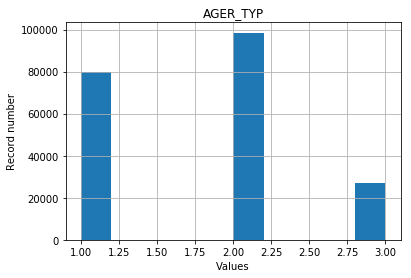

 17%|█▋        | 1/6 [00:00<00:01,  3.76it/s]

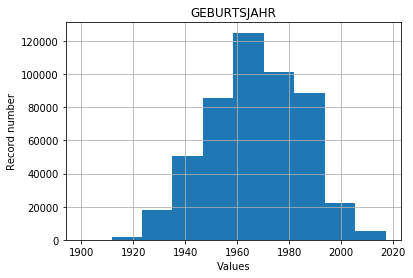

 33%|███▎      | 2/6 [00:00<00:00,  4.19it/s]

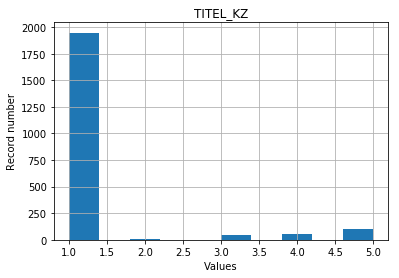

 50%|█████     | 3/6 [00:00<00:00,  4.60it/s]

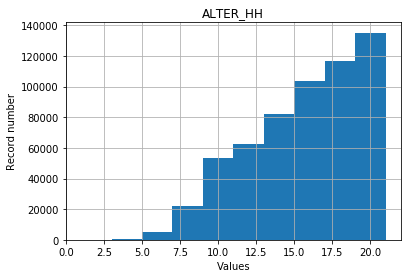

 67%|██████▋   | 4/6 [00:00<00:00,  4.89it/s]

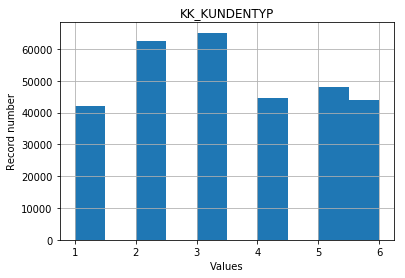

 83%|████████▎ | 5/6 [00:00<00:00,  5.25it/s]

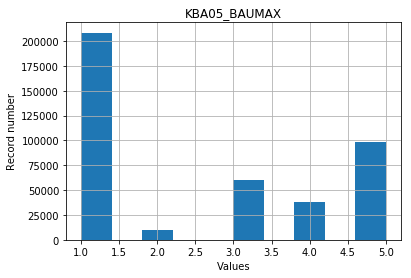

100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


In [25]:
# Investigate patterns in the amount of missing data in each column.
for index in tqdm(columns_to_drop):
    azdias[index].hist()
    plt.xlabel('Values')
    plt.ylabel('Record number')
    plt.title(index);
    plt.show()


In [26]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_transformed_clean = azdias.drop(columns_to_drop, axis = 1)
print("Result 2 : {}".format(azdias_transformed_clean.shape)) 
print('Index of deleted columns: ',columns_to_drop)

Result 2 : (891221, 79)
Index of deleted columns:  Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


In [27]:
azdias_transformed_clean.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,6.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [28]:
# Clean feat_info df too
feat_info_clean = feat_info[feat_info.index.isin(columns_to_drop) == False]
feat_info_clean.shape

(79, 3)

#### Discussion 1.1.2: Assess Missing Data in Each Column

The global missing value distribution for data is right-skewed. 79 columns have less or equal than MISSING_RATE (20% ) missing data. We keep these columns for further transformation. 
The columns with missing values rate greater than MISSING_RATE are:

- 'AGER_TYP' - Best-ager typology
- 'GEBURTSJAHR' - Year of birth
- 'TITEL_KZ'- Academic title flag
- 'ALTER_HH'- Main age within the household
- 'KK_KUNDENTYP' - Consumer pattern over past 12 months
-  KBA05_BAUMAX' - Most common building within the microcell


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [29]:
 azdias_transformed_clean['COUNT_NAN'] = azdias_transformed_clean.isna().sum(axis = 1)
 #azdias_transformed_clean['COUNT_NAN']    

In [30]:
azdias_transformed_clean.shape

(891221, 80)

In [31]:
row_value_missing = azdias_transformed_clean['COUNT_NAN'][azdias_transformed_clean['COUNT_NAN']> 0]
max(row_value_missing)

49

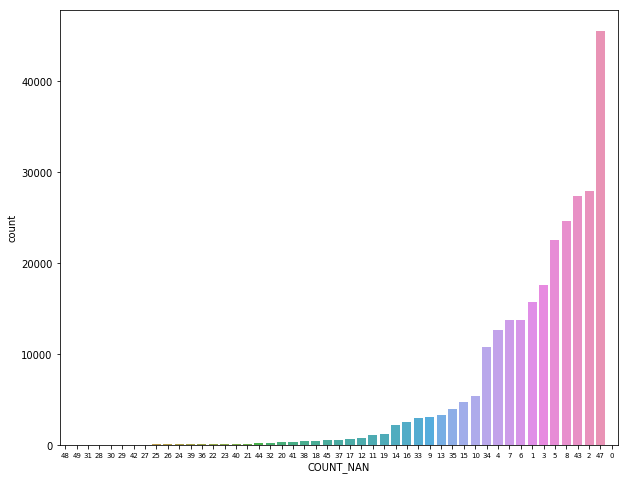

In [32]:
# How much data is missing in each row of the dataset?
plt.figure(figsize=(10, 8))
plt.rcParams["xtick.labelsize"] = 7
sns.countplot(data = azdias_transformed_clean, 
              x = row_value_missing, 
              order = azdias_transformed_clean['COUNT_NAN'].value_counts().sort_values(ascending=True).index)


In [33]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_rich_subset = azdias_transformed_clean[azdias_transformed_clean['COUNT_NAN'] < THRESHOLD]
azdias_rich_subset.shape

(797906, 80)

In [34]:
azdias_poor_subset = azdias_transformed_clean[azdias_transformed_clean['COUNT_NAN'] >= THRESHOLD]
azdias_poor_subset.shape

(93315, 80)

<Figure size 216x216 with 0 Axes>

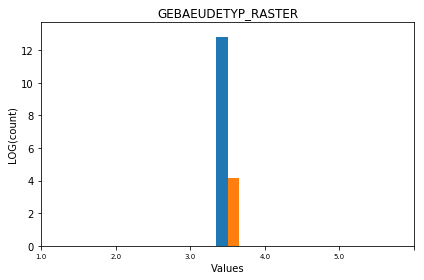

<Figure size 216x216 with 0 Axes>

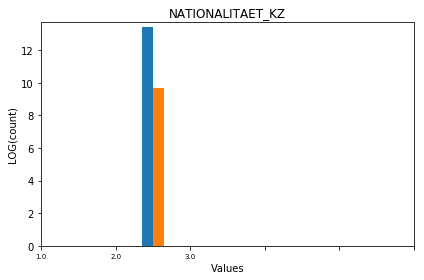

<Figure size 216x216 with 0 Axes>

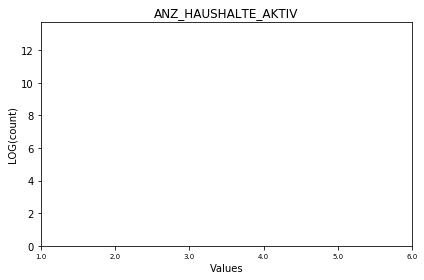

<Figure size 216x216 with 0 Axes>

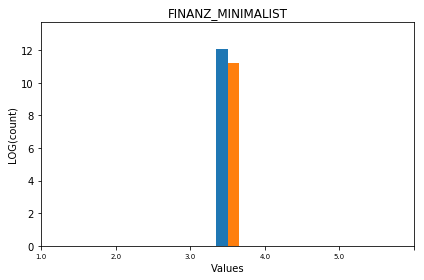

<Figure size 216x216 with 0 Axes>

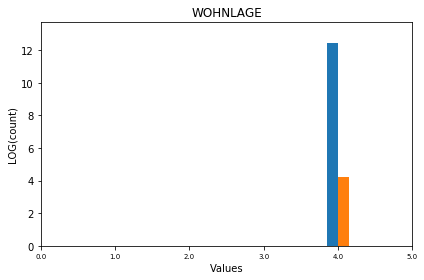

<Figure size 216x216 with 0 Axes>

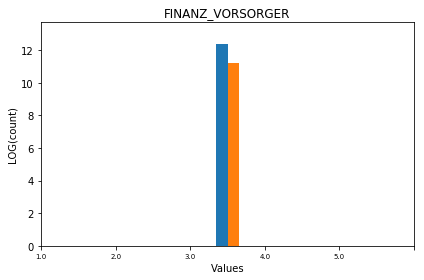

<Figure size 216x216 with 0 Axes>

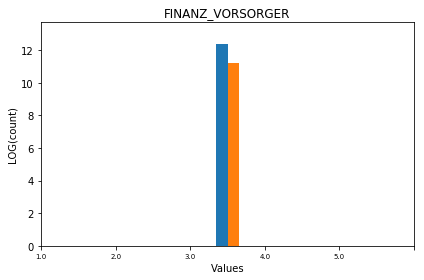

<Figure size 216x216 with 0 Axes>

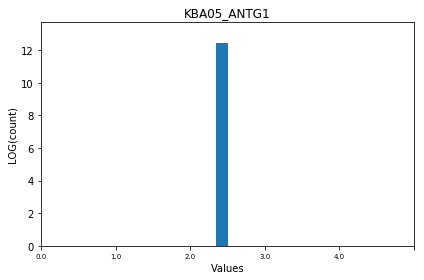

<Figure size 216x216 with 0 Axes>

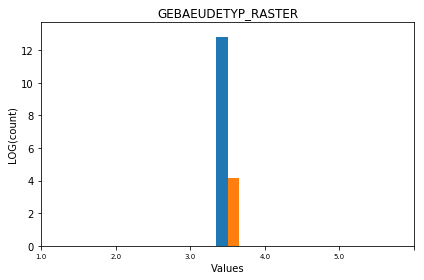

<Figure size 216x216 with 0 Axes>

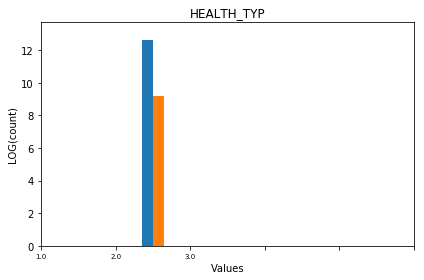

In [35]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

width = 0.3 # the width of the bars: can also be len(x) sequence
for int in range(10):
    index = random.choice(azdias_rich_subset.columns)
    plt.figure(figsize=(3, 3))
    fig, ax = plt.subplots()
    # With few missing values
    #plt.subplot(121)
    value_list = azdias_rich_subset[index].value_counts().index
    rich_value_count = list(azdias_rich_subset[index].value_counts())
    value_list = np.array(azdias_rich_subset[index].value_counts().index)
    value_list.sort(axis = 0)
    ind = len(rich_value_count)#FIXME np.arange(len(value_list)) 
    ax.bar(ind - width/2,np.log(rich_value_count), width, label='Few')


    #  With many missing values
    #plt.subplot(122) 
    poor_value_count = list(azdias_poor_subset[index].value_counts())
    ax.bar(ind + width/2,np.log(poor_value_count), width, label="Many")
    plt.title(index)
    ax.set_ylabel('LOG(count)')
    ax.set_xlabel('Values')
    ax.set_xticklabels(value_list)
    plt.axis([0, 10, 0, np.log(900000)])
    fig.tight_layout()

    plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

The assement of missing values by rows demonstrates that the maximum number of missing data in each row is 49 (max(row_value_missing)) attributes out of 79 attributes left after dropping columns. The distribution of amount of missing data in each row demonstrates that most of the rows have less than THRESHOLD missing attributes. So, the data was devided into two subsets: azdias with <= THRESHOLD missing attributes (797906 rows) and azdias with > THRESHOLD missing attributes (93315 rows). Comparison of distribution of values for 10 randomly choosen columns demonstrates that generally the distribution is similar for the two data sets (see bar plot for 10 different attributes with few nan vs many nan datasets above).

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [36]:
# How many features are there of each data type?
feat_info_clean['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [37]:
if feat_info_clean['type'].isnull().sum() > 0:
    print('Warning! {} columns do not have data type'.format(feat_info_clean['type'].isnull().sum()))
else:
    print('All columns have a datatype.')


All columns have a datatype.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [38]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_columns = feat_info_clean[feat_info_clean['type'] == 'categorical']
categorical_columns

,information_level,type,missing_or_unknown
attribute,,,
ANREDE_KZ,person,categorical,"[-1, 0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZTYP,person,categorical,[-1]
GFK_URLAUBERTYP,person,categorical,[]
GREEN_AVANTGARDE,person,categorical,[]
LP_FAMILIE_FEIN,person,categorical,[0]
LP_FAMILIE_GROB,person,categorical,[0]
LP_STATUS_FEIN,person,categorical,[0]
LP_STATUS_GROB,person,categorical,[0]


In [39]:
# Check categorical variable whether it is binary or multi-level
binary_columns = []
multi_level_columns = []
for attribute in categorical_columns.index:
    value_count = len(azdias_rich_subset[attribute].value_counts())
    if value_count == BINARY_VALUE_NB:
        binary_columns.append(attribute)
    else:
        #print('{} has {} attributes.'.format(attribute,  value_count))
        if value_count < MAX_NB_MULTI_LEVEL_VARIABLES:
            multi_level_columns.append(attribute)
        

In [40]:
binary_columns

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [41]:
multi_level_columns

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

As CAMEO_DEU_2015 has 44 attributes we wont keep it for further analysis.

In [42]:
azdias_rich_subset.drop('CAMEO_DEU_2015', axis = 1, inplace = True)


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [43]:
#Check types of binary values
for column in binary_columns:
    value_count = azdias_rich_subset[column].unique()
    print(column, value_count )


ANREDE_KZ [2. 1.]
GREEN_AVANTGARDE [0. 1.]
SOHO_KZ [1. 0.]
VERS_TYP [ 2.  1. nan]
OST_WEST_KZ ['W' 'O']


In [44]:
#Replace non numerical values
azdias_rich_subset['OST_WEST_KZ'] = azdias_rich_subset['OST_WEST_KZ'].replace({'O':0.0, 'W':1.0})


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
#Check the column OST_WEST_KZ after the modificaton
azdias_rich_subset['OST_WEST_KZ'].value_counts()

1.0    629388
0.0    168518
Name: OST_WEST_KZ, dtype: int64

In [46]:
# Drop count column which is not needed anymore
azdias_rich_subset.drop('COUNT_NAN', axis = 1, inplace = True)

In [47]:
print("Step 3 : Result {}".format(azdias_rich_subset.shape))

Step 3 : Result (797906, 78)


In [168]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_encoded_ = pd.get_dummies(azdias_rich_subset, columns = binary_columns)
print("Step 4.1 : Result {}".format(azdias_encoded_.shape))

Step 4.1 : Result (797906, 83)


In [169]:
azdias_encoded = pd.get_dummies(azdias_encoded_, columns = multi_level_columns)
print("Step 4.2 : Result {}".format(azdias_encoded.shape))

Step 4.2 : Result (797906, 155)


In [170]:
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,...,1,0,0,0,0,0,0,0,1,0
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,...,0,0,0,0,1,0,0,0,0,0
3,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,32.0,10.0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,8.0,2.0,...,0,0,0,0,0,0,0,0,1,0


#### Discussion 1.2.1: Re-Encode Categorical Features
Beside the column OST_WEST_KZ, there was no need to change the columns with binary values. The walues of the column OST_WEST_KZ were replaced by 0 and 1. 
However for multi-level categoricals columns the transformation by get_dummies() fonction is necessary. Among categorical columns, only the ones with less than 15 possible values were kept. As CAMEO_DEU_2015 has 44 attributes we wont use it for further analysis. After re-encoding categorical values we have 155 columns.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [171]:
feat_info_clean[feat_info_clean['type'] == 'mixed']

,information_level,type,missing_or_unknown
attribute,,,
LP_LEBENSPHASE_FEIN,person,mixed,[0]
LP_LEBENSPHASE_GROB,person,mixed,[0]
PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
WOHNLAGE,building,mixed,[-1]
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [172]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_encoded['PRAEGENDE_JUGENDJAHRE'].unique()

array([14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4., nan,  2.,  1.,
       12., 13.,  7.])

In [173]:
# Engineer new column `DECADE`
dict = {1: 40, 2:40, 3: 50,4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}
azdias_encoded['DECADE'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].replace(dict)
# Engineer new column `MOVEMENT`
mainstream = [1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0]
avantgarde = [2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0]

main_values = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].isin(mainstream)
azdias_encoded.loc[main_values, 'MOVEMENT'] = 0
avant_values = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].isin(avantgarde)
azdias_encoded.loc[avant_values, 'MOVEMENT'] = 1

In [174]:
azdias_encoded['DECADE'].value_counts()

90.0    225504
70.0    175167
80.0    151747
60.0    114343
50.0     74291
40.0     28157
Name: DECADE, dtype: int64

In [175]:
azdias_encoded['MOVEMENT'].value_counts()

0.0    594001
1.0    175208
Name: MOVEMENT, dtype: int64

In [176]:
azdias_encoded['CAMEO_INTL_2015'].value_counts()

51    133691
41     92336
24     91147
14     62880
43     56671
54     45390
25     39624
22     33149
23     26732
13     26332
45     26132
55     23954
52     20542
31     19012
34     18524
15     16974
44     14820
12     13245
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [177]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Create new column 'WEALTH'
if azdias_encoded['CAMEO_INTL_2015'].dtype == 'float64':
    azdias_encoded['WEALTH'] = azdias_encoded['CAMEO_INTL_2015'] // 10
    azdias_encoded['LIFE_STAGE'] = azdias_encoded['CAMEO_INTL_2015'] % 10
else:
    azdias_encoded['WEALTH'] = azdias_encoded['CAMEO_INTL_2015'].str[0].astype('float')
    azdias_encoded['LIFE_STAGE'] = azdias_encoded['CAMEO_INTL_2015'].str[1].astype('float')


In [178]:
azdias_encoded['WEALTH'].value_counts()

5.0    223577
2.0    190652
4.0    189959
1.0    119431
3.0     68181
Name: WEALTH, dtype: int64

In [179]:
azdias_encoded['LIFE_STAGE'].value_counts()

1.0    245039
4.0    232761
3.0    119670
5.0    117040
2.0     77290
Name: LIFE_STAGE, dtype: int64

In [180]:
# These columns are splited to 2 new nes and are not needed 
azdias_encoded.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
azdias_encoded.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

# This column is to be dropped because of number of possible categories.
azdias_encoded.drop('LP_LEBENSPHASE_FEIN', axis = 1, inplace = True)
azdias_encoded.shape

(797906, 156)

In [181]:
feat_info_clean[feat_info_clean['type'] == 'mixed']

,information_level,type,missing_or_unknown
attribute,,,
LP_LEBENSPHASE_FEIN,person,mixed,[0]
LP_LEBENSPHASE_GROB,person,mixed,[0]
PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
WOHNLAGE,building,mixed,[-1]
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [182]:
#check LP_LEBENSPHASE_GROB
azdias_encoded['LP_LEBENSPHASE_GROB'].value_counts()

2.0     149523
1.0     131107
3.0     109687
12.0     69498
4.0      51206
5.0      47166
9.0      46030
10.0     38026
11.0     31158
8.0      28720
6.0      27429
7.0      21161
Name: LP_LEBENSPHASE_GROB, dtype: int64

In [183]:
#check LP_LEBENSPHASE_GROB
azdias_encoded['WOHNLAGE'].value_counts()

3.0    249693
7.0    169304
4.0    135959
2.0    100364
5.0     74336
1.0     43913
8.0     17455
0.0      6882
Name: WOHNLAGE, dtype: int64

In [184]:
# Re-encode `LP_LEBENSPHASE_GROB` and `WOHNLAGE` to be kept in the analysis.
azdias_final = pd.get_dummies(azdias_encoded, columns=['LP_LEBENSPHASE_GROB', 'WOHNLAGE'])
print("Step 5 : Result {}".format(azdias_final.shape))

Step 5 : Result (797906, 174)


#### Discussion 1.2.2: Engineer Mixed-Type Features

Here below the details of transformation done for mixe-type columns described below:

- LP_LEBENSPHASE_FEIN - This column is drop beacause of number of possible categories.
- LP_LEBENSPHASE_GROB - The column contains categorical values and was re-encoded.
- PRAEGENDE_JUGENDJAHRE - This column was replaced by 2 new ones following the steps outlined before.
- WOHNLAGE - As LP_LEBENSPHASE_GROB, it contains categorical values and it was re-encoded.
- CAMEO_INTL_2015 - This column was replaced by 2 new ones following the steps outlined before.
- PLZ8_BAUMAX - Nothing was done.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [185]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797906 entries, 1 to 891220
Columns: 174 entries, ALTERSKATEGORIE_GROB to WOHNLAGE_8.0
dtypes: float64(60), uint8(114)
memory usage: 458.1 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [66]:

def clean_data(df, columns_to_drop, multi_level_columns, binary_columns):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    print("Step 0 : Begin transformation...")
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs
    
    print("Step 1 : Replace missing values...")
    for column in df.columns:
        missing_values_row = df[column].isin(feat_info.at[column, 'missing_or_unknown'])
        df.at[missing_values_row, column] = np.NaN  
        
    print("Result 1 : {}".format(df.shape))  
     
    print("Step 2 : Drop columns with many missing values...")       
    # remove selected columns and rows, ...
    df = df.drop(columns_to_drop, axis = 1)
    print("Result 2 : {}".format(df.shape)) 
    
    df['COUNT_NAN'] = df.isna().sum(axis = 1)
    df_changed = df[df['COUNT_NAN'] < THRESHOLD]


    print("Step 3 : Re-encode...{}".format(df_changed.shape))
    print("Step 3.1 : Re-encode OST_WEST_KZ and drop CAMEO_DEU_2015...")
    # Re-encode, and engineer column values.
    df_changed = df_changed.drop(['CAMEO_DEU_2015','COUNT_NAN'], axis = 1)
    df_changed['OST_WEST_KZ'] = df_changed['OST_WEST_KZ'].replace({'O':0.0, 'W':1.0}) 
    print("Step 3.1 : Result {}".format(df_changed['OST_WEST_KZ'].value_counts()))
    print("Step 3 : Result {}".format(df_changed.shape))
    
    print("Step 4 : Get dummies")
    df_encoded_ = pd.get_dummies(df_changed, columns = binary_columns)
    print("Step 4.1 : Result {}".format(df_encoded_.shape))
    df_encoded = pd.get_dummies(df_encoded_, columns = multi_level_columns)
    print("Step 4.2 : Result {}".format(df_encoded.shape))
          
    # Engineer mixed-type features
    dict = {1: 40, 2:40, 3: 50,4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}
    df_encoded['DECADE'] = df_encoded_['PRAEGENDE_JUGENDJAHRE'].replace(dict)

    main = df_encoded['PRAEGENDE_JUGENDJAHRE'].isin([1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0])
    df_encoded.loc[main, 'MOVEMENT'] = 0
    avant = df_encoded['PRAEGENDE_JUGENDJAHRE'].isin([2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0])
    df_encoded.loc[avant, 'MOVEMENT'] = 1
    
    if df_encoded['CAMEO_INTL_2015'].dtype == 'float64':
        df_encoded['WEALTH'] = df_encoded['CAMEO_INTL_2015'] // 10
        df_encoded['LIFE_STAGE'] = df_encoded['CAMEO_INTL_2015'] % 10
    else:
        df_encoded['WEALTH'] = df_encoded['CAMEO_INTL_2015'].str[0].astype('float')
        df_encoded['LIFE_STAGE'] = df_encoded['CAMEO_INTL_2015'].str[1].astype('float')
    
    print("Step 5 : Final transformations...")    
    df_final =  df_encoded.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN'], axis=1)
    df_final = pd.get_dummies(df_final, columns=['LP_LEBENSPHASE_GROB', 'WOHNLAGE'])
    print("Step 5 : Result {}".format(df_final.shape))
    # Return the result dataframe.
    print("Done")
    return df_final

In [186]:
azdias2 = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')


In [187]:
azdias_final2 = clean_data(azdias2, list(columns_to_drop), multi_level_columns, binary_columns)


Step 0 : Begin transformation...
Step 1 : Replace missing values...
Result 1 : (891221, 85)
Step 2 : Drop columns with many missing values...
Result 2 : (891221, 79)
Step 3 : Re-encode...(797906, 80)
Step 3.1 : Re-encode OST_WEST_KZ and drop CAMEO_DEU_2015...
Step 3.1 : Result 1.0    629388
0.0    168518
Name: OST_WEST_KZ, dtype: int64
Step 3 : Result (797906, 78)
Step 4 : Get dummies
Step 4.1 : Result (797906, 83)
Step 4.2 : Result (797906, 155)
Step 5 : Final transformations...
Step 5 : Result (797906, 174)
Done


In [188]:
print("Check the result of the function : {}".
      format(azdias_final.shape == azdias_final2.shape))

Check the result of the function : True


In [164]:
def compare_df(df1, df2):
    columns = []
    df1_column_list = list(df1.columns)
    df2_column_list = list(df2.columns)

    if len(df1_column_list)< len(df2_column_list):
        df_long = df2_column_list
        df_court = df1_column_list
    else:
        df_long = df1_column_list
        df_court = df2_column_list
        
    for item in df_long:
        if item in df_court:
            pass
        else:
            columns.append(item) 
    return columns

In [189]:
value_columns = compare_df(azdias_final, azdias_final2)
value_columns

[]

The difference in the column numbers after the applicaton of get_dummies() is related to the new columns created based on values of categorical columns. In order to contunue all identified columns are deleted.

In [190]:
azdias_final2.drop(value_columns, axis = 1, inplace = True)
azdias_final2.shape

(797906, 174)

In [191]:
value_columns = compare_df(azdias_final, azdias_final2)
value_columns

[]

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [120]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer()
azdias_imputed = imputer.fit_transform(azdias_final2)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [121]:
# Apply feature scaling to the general population demographics data.
sd_scaler = StandardScaler()
azdias_scaled = sd_scaler.fit_transform(azdias_imputed)


### Discussion 2.1: Apply Feature Scaling

Using the default values for Imputer, all the missing values were replaced by the mean of the column. Next the data was scaled by using the default values defined for the function.




### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [122]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

Text(0.5, 1.0, 'Explained Variance Per Principal Component')

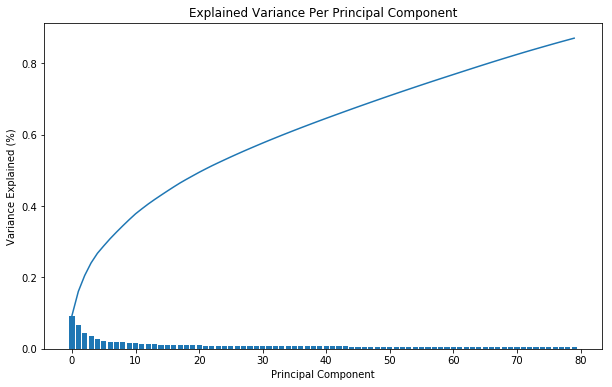

In [253]:
# Investigate the variance accounted for by each principal component.
values = pca.explained_variance_ratio_
ind = np.arange(len(values))

plt.figure(figsize=(10, 6))
ax = plt.subplot()
cumsum_values = np.cumsum(values)
ax.bar(ind, values)
ax.plot(ind, cumsum_values)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')

In [124]:
sum(pca.explained_variance_ratio_)

1.0

In [193]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(PCA_N_COMPONENTS)
azdias_pca = pca.fit_transform(azdias_scaled)


Text(0.5, 1.0, 'Explained Variance Per Principal Component')

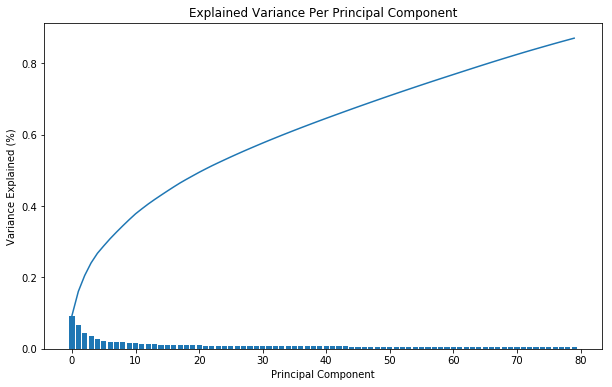

In [254]:
# Investigate the variance accounted for by each principal component.
values = pca.explained_variance_ratio_
ind = np.arange(len(values))

plt.figure(figsize=(10, 6))
ax = plt.subplot()
cumsum_values = np.cumsum(values)
ax.bar(ind, values)
ax.plot(ind, cumsum_values)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')

In [195]:
sum(pca.explained_variance_ratio_)

0.8698679871093973

### Discussion 2.2: Perform Dimensionality Reduction

In the first application of principal component analysis the number of component was not specified and as we see from the result it takes all the components and the sum of variance explained by the selected components is 1. In the second, the number of components is specified by PCA_N_COMPONENTS and the sum of the variance explained by each of the selected components is greater 85%. It is an acceptable percentage and we will keep this PCA object for further processing.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [196]:
def weigt_principal_component(components, nb):
    print(components.iloc[nb].sort_values(ascending=False))


In [197]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# PCA components

components = pd.DataFrame(np.round(pca.components_, 2), columns = azdias_final.columns)
weigt_principal_component(components, 0)

LP_STATUS_GROB_1.0          0.19
PLZ8_ANTG3                  0.18
HH_EINKOMMEN_SCORE          0.18
WEALTH                      0.17
PLZ8_ANTG4                  0.17
PLZ8_BAUMAX                 0.17
FINANZ_HAUSBAUER            0.15
ORTSGR_KLS9                 0.15
EWDICHTE                    0.15
LP_STATUS_FEIN_1.0          0.13
PLZ8_ANTG2                  0.12
KBA05_ANTG4                 0.12
ARBEIT                      0.11
LP_LEBENSPHASE_GROB_1.0     0.11
GREEN_AVANTGARDE_0.0        0.11
FINANZTYP_1.0               0.11
CAMEO_DEUG_2015_9           0.11
KBA05_ANTG3                 0.11
LP_STATUS_FEIN_2.0          0.11
FINANZ_SPARER               0.11
ANZ_HAUSHALTE_AKTIV         0.11
RELAT_AB                    0.10
LP_FAMILIE_GROB_1.0         0.09
CAMEO_DEUG_2015_8           0.09
LP_FAMILIE_FEIN_1.0         0.09
SEMIO_PFLICHT               0.08
DECADE                      0.07
SEMIO_REL                   0.07
ZABEOTYP_5.0                0.07
SEMIO_RAT                   0.07
          

In [198]:
dims = ['Dim {}'.format(i) 
                           for i in range(1,len(pca.components_)+1)]
components['Dim'] = dims
components.set_index('Dim')

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,WOHNLAGE_0.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0
Dim,,,,,,,,,,,,,,,,,,,,,
Dim 1,-0.08,-0.19,0.11,-0.08,0.05,0.05,0.15,0.02,-0.01,0.02,...,-0.05,-0.09,-0.01,-0.02,-0.01,0.03,0.07,0.05,-0.10,-0.04
Dim 2,0.23,0.09,-0.22,0.22,-0.20,-0.21,0.08,-0.05,0.15,-0.06,...,-0.07,0.02,-0.02,0.01,0.01,0.02,0.02,0.01,-0.04,-0.03
Dim 3,0.02,0.12,-0.05,0.04,-0.14,-0.04,-0.06,-0.00,0.07,0.24,...,0.01,0.01,-0.00,0.02,0.01,0.01,0.01,0.02,-0.04,-0.02
Dim 4,-0.02,-0.00,0.01,-0.01,-0.06,0.05,-0.02,-0.01,-0.01,-0.03,...,0.06,0.07,-0.00,0.09,0.07,0.07,0.01,-0.00,-0.18,-0.05
Dim 5,0.05,0.02,-0.03,0.04,0.03,-0.10,0.02,-0.01,0.01,0.02,...,0.06,0.13,-0.00,-0.08,-0.04,-0.01,0.03,0.03,0.03,0.02
Dim 6,0.02,0.12,-0.02,-0.03,-0.03,-0.02,-0.17,0.05,0.02,-0.02,...,-0.03,-0.10,0.09,-0.03,-0.00,0.02,0.02,0.03,-0.10,0.09
Dim 7,-0.01,-0.05,0.00,0.02,-0.00,0.02,0.08,-0.03,-0.01,0.00,...,-0.11,-0.16,0.00,0.02,0.01,0.00,-0.01,-0.02,0.01,-0.01
Dim 8,0.05,-0.06,-0.02,0.09,-0.05,0.02,0.06,0.00,0.04,0.02,...,-0.10,-0.09,-0.01,0.03,0.02,-0.03,-0.01,-0.03,0.03,-0.01
Dim 9,0.01,0.03,-0.02,-0.01,-0.00,-0.05,-0.00,-0.01,-0.01,0.02,...,-0.00,0.02,-0.02,0.01,-0.01,0.01,-0.01,-0.00,0.01,-0.01


In [80]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weigt_principal_component(components, 1)

ALTERSKATEGORIE_GROB        0.23
FINANZ_VORSORGER            0.22
ZABEOTYP_3.0                0.20
SEMIO_ERL                   0.17
SEMIO_LUST                  0.16
LP_LEBENSPHASE_GROB_2.0     0.15
RETOURTYP_BK_S              0.15
W_KEIT_KIND_HH              0.13
CJT_GESAMTTYP_2.0           0.10
FINANZTYP_5.0               0.10
LP_STATUS_FEIN_1.0          0.09
FINANZ_MINIMALIST           0.09
FINANZTYP_2.0               0.09
FINANZ_HAUSBAUER            0.08
SEMIO_KRIT                  0.07
FINANZTYP_6.0               0.07
SHOPPER_TYP_3.0             0.07
CJT_GESAMTTYP_1.0           0.07
PLZ8_ANTG3                  0.06
LP_FAMILIE_GROB_1.0         0.06
ORTSGR_KLS9                 0.06
EWDICHTE                    0.06
NATIONALITAET_KZ_1.0        0.06
LP_FAMILIE_FEIN_1.0         0.06
PLZ8_BAUMAX                 0.06
GFK_URLAUBERTYP_4.0         0.06
PLZ8_ANTG4                  0.06
LP_LEBENSPHASE_GROB_10.0    0.05
WOHNDAUER_2008              0.05
KBA05_ANTG4                 0.05
          

In [81]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weigt_principal_component(components, 2)

SEMIO_VERT                 0.31
SEMIO_SOZ                  0.26
SEMIO_FAM                  0.26
SEMIO_KULT                 0.25
FINANZ_MINIMALIST          0.13
FINANZTYP_5.0              0.13
SEMIO_REL                  0.12
ZABEOTYP_1.0               0.12
SHOPPER_TYP_0.0            0.12
SEMIO_MAT                  0.09
MOVEMENT                   0.08
GREEN_AVANTGARDE           0.08
RETOURTYP_BK_S             0.07
ORTSGR_KLS9                0.07
EWDICHTE                   0.07
W_KEIT_KIND_HH             0.06
LP_STATUS_GROB_5.0         0.06
LP_STATUS_FEIN_10.0        0.06
SHOPPER_TYP_1.0            0.05
PLZ8_BAUMAX                0.05
PLZ8_ANTG4                 0.05
ZABEOTYP_6.0               0.05
PLZ8_ANTG3                 0.05
RELAT_AB                   0.04
LP_STATUS_FEIN_3.0         0.04
PLZ8_ANTG2                 0.04
ARBEIT                     0.04
LP_STATUS_FEIN_1.0         0.04
FINANZ_VORSORGER           0.04
LP_STATUS_GROB_3.0         0.04
                           ... 
LP_STATU

### Discussion 2.3: Interpret Principal Components

For each principal component or dimension, the top 3 and bottom 3 weights with their corresponding feature names will be investigated for any associations.

First principal component:

- LP_STATUS_GROB_1.0          0.19 - Social status, rough scale,
- HH_EINKOMMEN_SCORE          0.18 - Estimated household net income
- PLZ8_ANTG3                  0.18 - Number of 6-10 family houses in the PLZ8 region
- PLZ8_ANTG4                  0.17 - Number of 10+ family houses in the PLZ8 region
- WEALTH                      0.17 - Wealth
- PLZ8_ANTG1                 -0.18 - Number of 1-2 family houses in the PLZ8 region
- KBA05_GBZ                  -0.18 - Number of buildings in the microcell
- KBA05_ANTG1                -0.19 - Number of 1-2 family houses in the microcell
- FINANZ_MINIMALIST          -0.19 - Financial typology
- MOBI_REGIO                 -0.20 - Movement patterns

Interpretation: The first principal component is strongly correlated with social status, estimated net income and number of 6+ family houses and wealth. Higher movement pattern, number od 1-2 family houses tend to negatively affect this principal component.

Second:

- ALTERSKATEGORIE_GROB        0.23 - Estimated age based on given name analysis
- FINANZ_VORSORGER            0.22 - Financial typology
- ZABEOTYP_3.0                0.20 - Energy consumption typology
- SEMIO_ERL                   0.17 - Personality typology
- SEMIO_LUST                  0.16 - Personality typology
- SEMIO_TRADV                -0.20 - Personality typology
- FINANZ_UNAUFFAELLIGER      -0.21 - Financial typology
- SEMIO_REL                  -0.21 - Personality typology
- FINANZ_SPARER              -0.22 - Financial typology
- DECADE                     -0.23 - Decades

Interpretation: The second principal component is oriented to personal data columns and is strongly correlated with age, financial avantage and energy consuption of person. Higher savings tend to negatively affect this principal component.

Dimension 3:

- SEMIO_VERT                 0.31 - Personality typology
- SEMIO_SOZ                  0.26 - Personality typology
- SEMIO_FAM                  0.26 - Personality typology
- SEMIO_KULT                 0.25 - Personality typology
- FINANZ_MINIMALIST          0.13 - Financial typology
- SEMIO_ERL                 -0.21 - Personality typology
- SEMIO_KRIT                -0.27 - Personality typology
- SEMIO_DOM                 -0.28 - Personality typology
- SEMIO_KAEM                -0.31 - Personality typology
- ANREDE_KZ                 -0.34 - Gender

Interpretation: The third principal component is primarily affected by the gender and other personal informations whinch are not explained in data description. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [104]:
# Over a number of different cluster counts...
scores_list = []
possible_k_values = range(2, 30, 2)
for k in tqdm(possible_k_values):
    # run k-means clustering on the data and...
    kmeans = MiniBatchKMeans(n_clusters = k, random_state=42)
    model = kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(azdias_pca))
    scores_list.append(score)




100%|██████████| 14/14 [00:56<00:00,  4.00s/it]

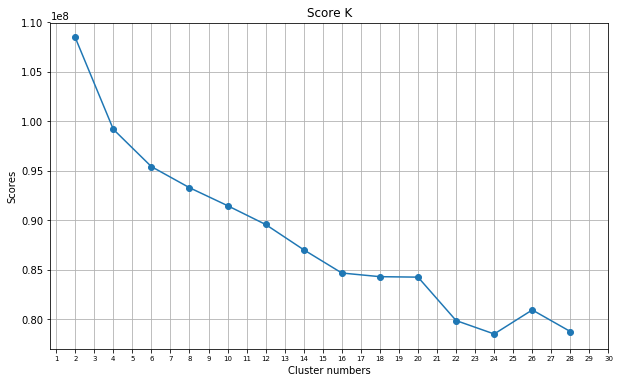

In [105]:
plt.figure(figsize=(10, 6))
ax = plt.subplot()
plt.plot(possible_k_values, scores_list, marker='o');
plt.xlabel('Cluster numbers');
plt.xticks(np.arange(1, 31, step=1))
plt.ylabel('Scores');
plt.title('Score K');
ax.grid(True)

In [106]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
azdias_predicted = KMeans(n_clusters=16, random_state=42).fit_predict(azdias_pca)


In [111]:
azdias_cluster = pd.DataFrame(np.round(azdias_pca, 2), columns = dims)
azdias_cluster.insert(loc = 0, column = 'Cluster', value = azdias_predicted)


In [112]:
azdias_cluster.head()

,Cluster,Dim 1,Dim 2,Dim 3,Dim 4,Dim 5,Dim 6,Dim 7,Dim 8,Dim 9,...,Dim 71,Dim 72,Dim 73,Dim 74,Dim 75,Dim 76,Dim 77,Dim 78,Dim 79,Dim 80
0,13,4.64,-4.18,-3.52,1.25,0.96,-0.12,1.88,2.96,7.10,...,1.71,-1.09,-1.70,-0.60,-1.22,-0.15,0.23,-0.29,0.57,-2.38
1,12,-0.04,-0.87,-3.21,0.65,-4.25,-2.19,0.50,1.32,-0.83,...,-0.21,0.35,-0.94,-0.31,-0.68,0.05,0.56,-0.74,0.33,0.64
2,2,-4.83,1.60,-1.55,-2.28,0.77,1.07,-0.33,-1.06,0.26,...,-0.27,-0.54,-0.32,-0.19,-1.20,-0.15,-0.08,1.48,-0.30,0.49
3,11,0.02,0.65,3.12,2.36,3.25,-2.13,-0.89,1.86,0.25,...,0.30,-0.37,0.20,0.31,0.77,0.46,-0.73,0.70,0.45,-0.81
4,9,-0.90,-0.51,-1.40,-4.21,-0.75,-2.83,0.79,1.92,-0.72,...,-0.25,-0.90,0.35,-1.12,0.65,0.68,-0.11,0.12,0.19,0.17


### Discussion 3.1: Apply Clustering to General Population

In order to find the optimal number of clusters for the azdias_pca MiniBatchKMeans was used. As it takes less processing time it is more appropiate for many iterations that are not definitive. 

The scree plot shows that the score and the  number of clusters are negatively correlated. The number of clusters is choosen from the interval (2, 30). By applying the 'elbow method' we find that the optimal number of clusters is 16.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [199]:
# Load in the customer demographics data.
customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ";")
customer.shape

(191652, 85)

In [200]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customer_cleaned = clean_data(customer, 
                              list(columns_to_drop), 
                              multi_level_columns, 
                              binary_columns)


Step 0 : Begin transformation...
Step 1 : Replace missing values...
Result 1 : (191652, 85)
Step 2 : Drop columns with many missing values...
Result 2 : (191652, 79)
Step 3 : Re-encode...(141701, 80)
Step 3.1 : Re-encode OST_WEST_KZ and drop CAMEO_DEU_2015...
Step 3.1 : Result 1.0    130359
0.0     11342
Name: OST_WEST_KZ, dtype: int64
Step 3 : Result (141701, 78)
Step 4 : Get dummies
Step 4.1 : Result (141701, 83)
Step 4.2 : Result (141701, 154)
Step 5 : Final transformations...
Step 5 : Result (141701, 173)
Done


In [202]:
customer_cleaned.shape

(141701, 173)

In [203]:
print(compare_df(customer_cleaned, azdias_final2))

['GEBAEUDETYP_5.0']


In [204]:
customer_cleaned['GEBAEUDETYP_5.0'] = 0

In [205]:
customer_imputed = imputer.transform(customer_cleaned)
customer_scaled = sd_scaler.transform(customer_imputed)
customer_pca = pca.transform(customer_scaled)
customer_predicted = kmeans.predict(customer_pca)

In [231]:
customer_clusters = pd.DataFrame(np.round(customer_pca, 2), columns = dims)
customer_clusters.insert(loc=0, column='Cluster', value = customer_predicted)
customer_clusters.set_index('Cluster')
customer_clusters.head()

,Cluster,Dim 1,Dim 2,Dim 3,Dim 4,Dim 5,Dim 6,Dim 7,Dim 8,Dim 9,...,Dim 71,Dim 72,Dim 73,Dim 74,Dim 75,Dim 76,Dim 77,Dim 78,Dim 79,Dim 80
0,18,9.70,6.05,7.57,1.86,5.04,3.77,0.17,-5.69,-0.97,...,6.14,7.92,0.03,-5.54,28.34,-23.41,-8.74,-29.96,-6.39,-10.25
1,20,13.05,9.10,2.98,4.32,1.35,5.33,-5.88,-6.82,0.13,...,1.09,4.89,2.92,-5.56,30.16,-20.12,-9.32,-31.13,-8.27,-6.05
2,18,7.40,3.60,5.74,-2.82,4.92,4.41,-4.16,-5.39,0.23,...,1.96,5.30,0.44,-5.85,22.38,-16.10,-6.17,-25.85,-5.29,-6.56
3,18,21.36,3.20,7.36,3.54,10.27,5.18,-8.24,-8.14,-0.97,...,11.22,12.74,-0.54,-10.32,39.32,-30.69,-10.56,-42.08,-10.10,-13.68
4,18,11.87,4.68,7.50,4.30,4.99,5.58,-0.62,-6.48,-1.41,...,6.36,7.40,1.37,-6.06,26.03,-24.60,-7.91,-35.96,-6.73,-4.72


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

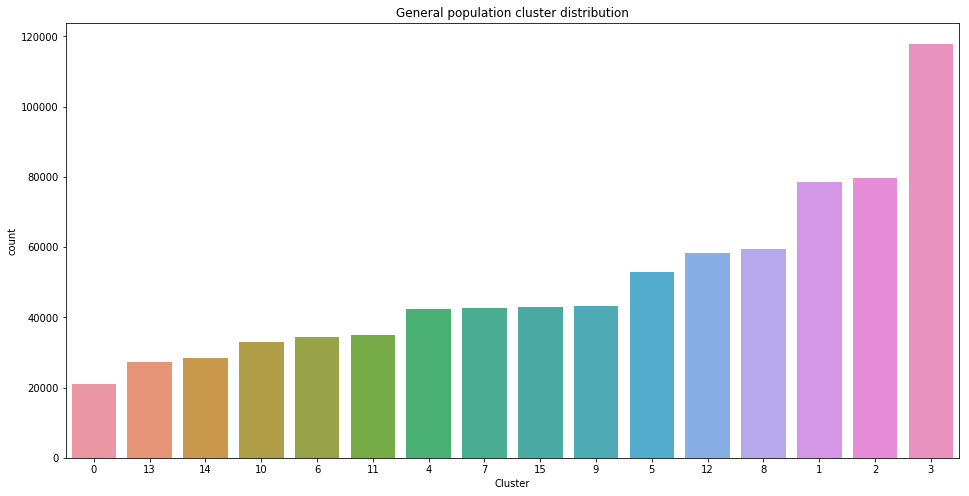

In [227]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# How much data is missing in each row of the dataset?
plt.figure(figsize=(16, 8))
plt.rcParams["xtick.labelsize"] = 10
plt.title("General population cluster distribution", fontsize=12)
sns.countplot(data = azdias_cluster, 
              x = azdias_cluster['Cluster'], 
              order = azdias_cluster['Cluster'].value_counts().sort_values(ascending=True).index)


In [241]:
azdias_cluster[azdias_cluster['Cluster']==3].sum(axis = 0).sort_values(ascending=False)

Dim 2      466475.75
Dim 1      379728.81
Cluster    353826.00
Dim 18      95728.76
Dim 24      77605.07
Dim 6       69692.86
Dim 5       42238.20
Dim 3       35200.06
Dim 42      25487.87
Dim 25      24289.45
Dim 58      23634.27
Dim 47      21905.10
Dim 27      21419.39
Dim 28      19168.33
Dim 74      16747.39
Dim 54      15750.04
Dim 13      15645.25
Dim 29      15286.54
Dim 26      14613.67
Dim 35      13473.40
Dim 36      12178.65
Dim 52      11998.95
Dim 73       9990.70
Dim 33       9748.75
Dim 45       9605.67
Dim 75       9110.47
Dim 64       8760.93
Dim 34       8525.92
Dim 49       8288.51
Dim 77       7207.50
             ...    
Dim 62      -5103.61
Dim 7       -5146.17
Dim 80      -5188.28
Dim 20      -5560.02
Dim 53      -5643.79
Dim 76      -5673.19
Dim 48      -6530.72
Dim 60      -6957.51
Dim 55      -7451.94
Dim 22      -8240.82
Dim 9       -8891.56
Dim 31      -9342.33
Dim 32      -9361.39
Dim 40      -9897.04
Dim 41     -12139.95
Dim 66     -12603.58
Dim 51     -1

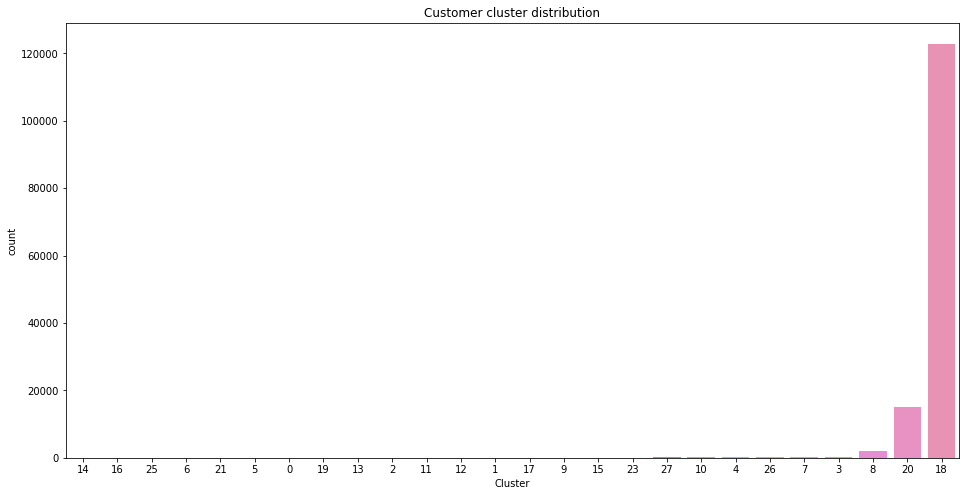

In [228]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

plt.figure(figsize=(16, 8))
plt.rcParams["xtick.labelsize"] = 10
plt.title("Customer cluster distribution", fontsize=12)
sns.countplot(data = customer_clusters, 
              x = customer_clusters['Cluster'], 
              order = customer_clusters['Cluster'].value_counts().sort_values(ascending=True).index)


In [251]:
customer_dims = customer_clusters[customer_clusters['Cluster']==18].sum(axis = 0).sort_values(ascending=False)
customer_dims

Dim 38     4060874.62
Dim 75     4047703.16
Dim 40     3621737.30
Dim 22     3268232.96
Dim 41     2925683.76
Dim 59     2904361.38
Dim 33     2900693.61
Dim 20     2775517.14
Dim 44     2470252.37
Dim 36     2454506.12
Dim 37     2357181.74
Dim 28     2356944.53
Cluster    2212254.00
Dim 13     2012922.36
Dim 34     1896328.71
Dim 1      1840610.47
Dim 32     1727816.49
Dim 52     1695612.57
Dim 53     1646950.85
Dim 60     1578063.39
Dim 63     1561377.26
Dim 55     1490797.15
Dim 30     1415096.34
Dim 67     1345703.25
Dim 72     1179444.05
Dim 31     1158570.31
Dim 71      998900.49
Dim 17      954890.81
Dim 49      873484.57
Dim 5       816229.73
              ...    
Dim 15     -428197.48
Dim 10     -580803.67
Dim 62     -606900.05
Dim 12     -616289.92
Dim 7      -742021.78
Dim 79     -903178.59
Dim 8      -922128.79
Dim 65     -933139.58
Dim 16     -959095.01
Dim 25     -973979.17
Dim 14     -991051.20
Dim 74     -993399.28
Dim 77    -1108504.83
Dim 24    -1238089.21
Dim 80    

In [252]:
components = pd.DataFrame(np.round(pca.components_, 2), columns = azdias_final.columns)
weigt_principal_component(components, 37)

WOHNLAGE_5.0                0.33
GFK_URLAUBERTYP_5.0         0.24
CAMEO_DEUG_2015_9           0.19
GFK_URLAUBERTYP_12.0        0.18
CJT_GESAMTTYP_2.0           0.17
WOHNLAGE_2.0                0.12
WOHNDAUER_2008              0.11
CJT_GESAMTTYP_3.0           0.11
LP_LEBENSPHASE_GROB_7.0     0.10
LP_LEBENSPHASE_GROB_4.0     0.10
LP_LEBENSPHASE_GROB_3.0     0.10
GEBAEUDETYP_2.0             0.10
LP_LEBENSPHASE_GROB_11.0    0.09
KBA05_ANTG3                 0.09
RETOURTYP_BK_S              0.09
NATIONALITAET_KZ_1.0        0.08
LP_FAMILIE_FEIN_7.0         0.08
CAMEO_DEUG_2015_1           0.08
LP_FAMILIE_FEIN_6.0         0.08
LP_FAMILIE_FEIN_4.0         0.08
CJT_GESAMTTYP_4.0           0.08
SHOPPER_TYP_2.0             0.07
GFK_URLAUBERTYP_9.0         0.07
CAMEO_DEUG_2015_2           0.06
LP_FAMILIE_FEIN_11.0        0.06
FINANZTYP_2.0               0.06
GFK_URLAUBERTYP_8.0         0.06
ZABEOTYP_3.0                0.06
LP_STATUS_FEIN_6.0          0.05
WOHNLAGE_7.0                0.05
          

### Discussion 3.3: Compare Customer Data to Demographics Data

The cluster most represented in general population is the cluster 3, but for the customer data the cluster better represented is 18. This means that customer data let us identify the target population for the given product.

The variable customer_dims contains the sorted list of the dimentions/components that let us identify data columns more important for further analysis and for identifying target population. The  dimention with max value is 38 which is linear conbinations of columns with higher coefficient:

- WOHNLAGE (Neighborhood quality), 
- GFK_URLAUBERTYP (Vacation habits), 
- CAMEO_DEUG_2015 (Wealth / Life Stage Typology),



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.